In [ ]:
#| default_exp theta

In [ ]:
#| export
import math
import os

import numpy as np
from numba import njit
from statsforecast.ets import nelder_mead
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from statsforecast.models import _seasonal_naive, _repeat_val_seas

# Theta Model

## thetacalc

In [ ]:
#| exporti
# Global variables 
STM = 0
OTM = 1
DSTM = 2
DOTM = 3
TOL = 1.0e-10
HUGEN = 1.0e10
NA = -99999.0
smalno = np.finfo(float).eps
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

In [ ]:
#| hide
from fastcore.test import test_eq
from statsforecast.utils import AirPassengers as ap

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def initstate(y, modeltype, level_0, alpha, theta):
    states = np.zeros((1, 5), dtype=np.float32)
    states[0, 0] = alpha * y[0] + (1 - alpha) * level_0 # level
    states[0, 1] = y[0] #mean y
    if modeltype in [DSTM, DOTM]:
        # dynamic models
        states[0, 2] = y[0] # An
        states[0, 3] = 0 # Bn
        states[0, 4] = y[0] # mu
    else:
        # nodynamic models
        n = len(y)
        Bn = 6 * (2 * np.mean(np.arange(1, n + 1) * y) - (1 + n) * np.mean(y)) / ( n ** 2 - 1)
        An = np.mean(y) - ( n + 1) * Bn / 2
        states[0, 2] = An
        states[0, 3] = Bn
        states[0, 4] = level_0 + (1 - 1 / theta) * (An + Bn)
        
    return states

In [ ]:
#| hide
level_0 = ap[0] / 2
alpha = 0.5
theta = 2
initstate(ap, modeltype=STM, level_0=level_0, alpha=alpha, theta=theta)
initstate(ap, modeltype=OTM, level_0=level_0, alpha=alpha, theta=theta)
initstate(ap, modeltype=DSTM, level_0=level_0, alpha=alpha, theta=theta)
initstate(ap, modeltype=DOTM, level_0=level_0, alpha=alpha, theta=theta)

array([[ 84., 112., 112.,   0., 112.]], dtype=float32)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def thetacalc(y: np.ndarray,
              states: np.ndarray, # states
              modeltype: int, 
              level_0: float, 
              alpha: float,
              theta: float, 
              e: np.ndarray, 
              amse: np.ndarray, 
              nmse: int) -> float:
    denom = np.zeros(nmse)
    f = np.zeros(nmse)
    # update first state
    states[0, :] = initstate(y=y, modeltype=modeltype, 
                             level_0=level_0, 
                             alpha=alpha, theta=theta) 
    
    amse[:nmse] = 0.
    e[0] = y[0] - states[0, 4]
    n = len(y)
    for i in range(1, n):
        # one step forecast 
        thetafcst(states=states, i=i, modeltype=modeltype, f=f, h=nmse, alpha=alpha, theta=theta)
        if math.fabs(f[0] - NA) < TOL:
            mse = NA
            return mse
        e[i] = y[i] - f[0]
        for j in range(nmse):
            if (i + j) < n:
                denom[j] += 1.
                tmp = y[i + j] - f[j]
                amse[j] = (amse[j] * (denom[j] - 1.0) + (tmp * tmp)) / denom[j]
        # update state
        thetaupdate(states=states, i=i, modeltype=modeltype, 
                    alpha=alpha, theta=theta, y=y[i], usemu=0)
    mse = np.sum(e[3:] ** 2) / np.mean(np.abs(y))
    return mse

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def thetafcst(states, i, 
              modeltype, 
              f, h, 
              alpha, theta):
    # obs:
    # forecast are obtained in a recursive manner
    # this is not standard, for example in ets
    #forecasts
    new_states = np.zeros((i + h, states.shape[1]), dtype=np.float32)
    new_states[:i] = states[:i]
    for i_h in range(h):
        thetaupdate(states=new_states, i=i + i_h, modeltype=modeltype, 
                    alpha=alpha, theta=theta, y=0, usemu=1)
        f[i_h] = new_states[i + i_h, 4]  # mu is the forecast

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def thetaupdate(states, i,
                modeltype, # kind of model 
                alpha, theta,
                y, usemu):
    # states
    # level, meany, An, Bn, mu
    # get params
    level = states[i - 1, 0]
    meany = states[i - 1, 1]
    An = states[i - 1, 2]
    Bn = states[i - 1, 3]
    # update mu
    states[i, 4] = level + (1 - 1 / theta) * (An * ((1 - alpha) ** i) + Bn * (1 - (1 - alpha)**(i + 1)) / alpha)
    if usemu:
        y = states[i, 4]
    # update level
    states[i, 0] = alpha * y + (1 - alpha) * level
    # update meany
    states[i, 1] = (i * meany + y) / (i + 1)
    # update Bn and An
    if modeltype in [DSTM, DOTM]:
        # dynamic models
        states[i, 3] = ((i - 1) * Bn + 6 * (y - meany) / (i + 1)) / (i + 2)
        states[i, 2] = states[i, 1] - states[i, 3] * (i + 2) / 2
    else:
        states[i, 2] = An
        states[i, 3] = Bn


In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def thetaforecast(states, n, modeltype, 
                  f, h, alpha, theta):
    # compute forecasts
    new_states = thetafcst(
        states=states, i=n, modeltype=modeltype, 
        f=f, h=h, 
        alpha=alpha,
        theta=theta
    ) 
    return new_states

In [ ]:
#| hide
#simple theta model tests
nmse_ = len(ap)
amse_ = np.zeros(30)
e_ = np.zeros(len(ap))
level_0 = ap[0] / 2
alpha = 0.5
theta = 2.
init_states = np.zeros((len(ap), 5), dtype=np.float32)
mse = thetacalc(
    y=ap,
    states=init_states, 
    modeltype=STM, 
    level_0=level_0, alpha=alpha, theta=theta,
    e=e_, amse=amse_, nmse=3
)
#verify we recover the fitted values
np.testing.assert_array_equal(
    ap - e_,
    init_states[:, -1]
)
#verify we get same fitted values than R
# use stm(AirPassengers, s=F, estimation=F, h = 12)
# to recover
np.testing.assert_array_almost_equal(
    init_states[:, -1][[0, 1, -1]],
    np.array([101.1550, 107.9061, 449.1692]), 
    decimal=2
)
# recover mse
test_eq(np.sum(e_[3:] ** 2) / np.mean(np.abs(ap)), mse)

# test forecasts
h = 5
fcsts = np.zeros(h, dtype=np.float32)
thetaforecast(
    states=init_states, n=len(ap), 
    modeltype=STM, 
    f=fcsts, h=h, 
    alpha=alpha,
    theta=theta
)
# test same forecast than R's
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([441.9132, 443.2418, 444.5704, 445.8990, 447.2276]),
    decimal=3
)

In [ ]:
#| hide
#optimal theta model tests
nmse_ = len(ap)
amse_ = np.zeros(30)
e_ = np.zeros(len(ap))
level_0 = ap[0] / 2
alpha = 0.5
theta = 2.
init_states = np.zeros((len(ap), 5), dtype=np.float32)
mse = thetacalc(
    y=ap,
    states=init_states, 
    modeltype=OTM, 
    level_0=level_0, alpha=alpha, theta=theta,
    e=e_, amse=amse_, nmse=3
)
#verify we recover the fitted values
np.testing.assert_array_equal(
    ap - e_,
    init_states[:, -1]
)
#verify we get same fitted values than R
# use stm(AirPassengers, s=F, estimation=F, h = 12)
# to recover
np.testing.assert_array_almost_equal(
    init_states[:, -1][[0, 1, -1]],
    np.array([101.1550, 107.9061, 449.1692]), 
    decimal=2
)
# recover mse
test_eq(np.sum(e_[3:] ** 2) / np.mean(np.abs(ap)), mse)

# test forecasts
h = 5
fcsts = np.zeros(h, dtype=np.float32)
thetaforecast(
    states=init_states, n=len(ap), 
    modeltype=OTM, 
    f=fcsts, h=h, 
    alpha=alpha,
    theta=theta
)
# test same forecast than R's
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([441.9132, 443.2418, 444.5704, 445.8990, 447.2276]),
    decimal=3
)

In [ ]:
#| hide
#dynamic simple theta model tests
nmse_ = len(ap)
amse_ = np.zeros(30)
e_ = np.zeros(len(ap))
level_0 = ap[0] / 2
alpha = 0.5
theta = 2.
init_states = np.zeros((len(ap), 5), dtype=np.float32)
mse = thetacalc(
    y=ap,
    states=init_states, 
    modeltype=DSTM, 
    level_0=level_0, alpha=alpha, theta=theta,
    e=e_, amse=amse_, nmse=3
)
#verify we recover the fitted values
np.testing.assert_array_equal(
    ap - e_,
    init_states[:, -1]
)
#verify we get same fitted values than R
# use dstm(AirPassengers, s=F, estimation=F, h = 12)
# to recover
np.testing.assert_array_almost_equal(
    init_states[:, -1][[0, 1, -1]],
    np.array([112.0000, 112.0000, 449.1805]), 
    decimal=2
)
# recover mse
test_eq(np.sum(e_[3:] ** 2) / np.mean(np.abs(ap)), mse)

# test forecasts
h = 5
fcsts = np.zeros(h, dtype=np.float32)
thetaforecast(
    states=init_states, n=len(ap), 
    modeltype=DSTM, 
    f=fcsts, h=h, 
    alpha=alpha,
    theta=theta
)
# test same forecast than R's
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([441.9132, 443.2330, 444.5484, 445.8594, 447.1659]),
    decimal=3
)

In [ ]:
#| hide
#dynamic optimal theta model tests
nmse_ = len(ap)
amse_ = np.zeros(30)
e_ = np.zeros(len(ap))
level_0 = ap[0] / 2
alpha = 0.5
theta = 2.
init_states = np.zeros((len(ap), 5), dtype=np.float32)
mse = thetacalc(
    y=ap,
    states=init_states, 
    modeltype=DOTM, 
    level_0=level_0, alpha=alpha, theta=theta,
    e=e_, amse=amse_, nmse=3
)
#verify we recover the fitted values
np.testing.assert_array_equal(
    ap - e_,
    init_states[:, -1]
)
#verify we get same fitted values than R
# use dstm(AirPassengers, s=F, estimation=F, h = 12)
# to recover
np.testing.assert_array_almost_equal(
    init_states[:, -1][[0, 1, -1]],
    np.array([112.0000, 112.0000, 449.1805]), 
    decimal=2
)
# recover mse
test_eq(np.sum(e_[3:] ** 2) / np.mean(np.abs(ap)), mse)

# test forecasts
h = 5
fcsts = np.zeros(h, dtype=np.float32)
thetaforecast(
    states=init_states, n=len(ap), 
    modeltype=DOTM, 
    f=fcsts, h=h, 
    alpha=alpha,
    theta=theta
)
# test same forecast than R's
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([441.9132, 443.2330, 444.5484, 445.8594, 447.1659]),
    decimal=3
)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def initparamtheta(level: float, alpha: float, theta: float,
                   y: np.ndarray,
                   modeltype: str):
    if modeltype in ['STM', 'DSTM']:
        if np.isnan(level):
            level = y[0] / 2
            optimize_level = 1
        else:
            optimize_level = 0
        if np.isnan(alpha):
            alpha = 0.5
            optimize_alpha = 1
        else:
            optimize_alpha = 0
        theta = 2. # no optimize
        optimize_theta = 0
    elif modeltype in ['OTM', 'DOTM']:
        if np.isnan(level):
            level = y[0] / 2
            optimize_level = 1
        else:
            optimize_level = 0
        if np.isnan(alpha):
            alpha = 0.5
            optimize_alpha = 1
        else:
            optimize_alpha = 0
        if np.isnan(theta):
            theta = 2.
            optimize_theta = 1
        else:
            optimize_theta = 0
    return {'level': level, 'optimize_level': optimize_level,
            'alpha': alpha, 'optimize_alpha': optimize_alpha,
            'theta': theta, 'optimize_theta': optimize_theta}

In [ ]:
#| hide
initparamtheta(level=np.nan, alpha=np.nan, theta=np.nan,
               y=ap,
               modeltype='DOTM')

DictType[unicode_type,float64]<iv=None>({level: 56.0, optimize_level: 1.0, alpha: 0.5, optimize_alpha: 1.0, theta: 2.0, optimize_theta: 1.0})

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def switch_theta(x: str):
    return {'STM': 0, 'OTM': 1, 'DSTM': 2, 'DOTM': 3}[x]

In [ ]:
#| hide
switch_theta('STM')

0

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def pegelsresid_theta(y: np.ndarray, 
                      modeltype: str, 
                      level: float, alpha: float,
                      theta: float, 
                      nmse: int):
    states = np.zeros((len(y), 5), dtype=np.float32)
    e = np.full_like(y, fill_value=np.nan)
    amse = np.full(nmse, fill_value=np.nan)
    mse = thetacalc(y=y, states=states, 
                    modeltype=switch_theta(modeltype), 
                    level_0=level, alpha=alpha, theta=theta, 
                    e=e, amse=amse, nmse=nmse)
    if not np.isnan(mse):
        if np.abs(mse + 99999) < 1e-7:
            lik = np.nan
    return amse, e, states, mse

In [ ]:
#| export
@njit(nogil=NOGIL, cache=CACHE)
def theta_target_fn(
        optimal_param,
        init_level,
        init_alpha,
        init_theta,
        opt_level,
        opt_alpha,
        opt_theta,
        y,
        modeltype,
        nmse
    ):
    states = np.zeros((len(y), 5), dtype=np.float32)
    j = 0
    if opt_level:
        level = optimal_param[j]
        j+=1
    else:
        level = init_level
        
    if opt_alpha:
        alpha = optimal_param[j]
        j+=1
    else:
        alpha = init_alpha
        
    if opt_theta:
        theta = optimal_param[j]
        j+=1
    else:
        theta = init_theta
        
    e = np.full_like(y, fill_value=np.nan)
    amse = np.full(nmse, fill_value=np.nan)
    mse = thetacalc(y=y, states=states, 
                    modeltype=switch_theta(modeltype), 
                    level_0=level, alpha=alpha, theta=theta, 
                    e=e, amse=amse, nmse=nmse)
    if mse < -1e10: 
        mse = -1e10 
    if math.isnan(mse): 
        mse = -np.inf
    if math.fabs(mse + 99999) < 1e-7: 
        mse = -np.inf
    return mse

In [ ]:
#| exporti
def optimize_theta_target_fn(
        init_par, optimize_params, y, 
        modeltype, nmse
    ):
    x0 = [init_par[key] for key, val in optimize_params.items() if val]
    x0 = np.array(x0, dtype=np.float32)
    if not len(x0):
        return
    
    init_level = init_par['theta']
    init_alpha = init_par['alpha']
    init_theta = init_par['theta']
    
    opt_level = optimize_params['level']
    opt_alpha = optimize_params['alpha']
    opt_theta = optimize_params['theta']
    
    res = nelder_mead(
        theta_target_fn, x0, 
        args=(
            init_level,
            init_alpha,
            init_theta,
            opt_level,
            opt_alpha,
            opt_theta,
            y,
            modeltype,
            nmse
        ),
        tol_std=1e-4, 
        lower=np.array([-1e10, 0.1, 1.0]),
        upper=np.array([1e10, 0.99, 1e10]),
        max_iter=1_000,
        adaptive=True,
    )
    return res

In [ ]:
#| exporti
def thetamodel(
        y: np.ndarray, m: int, 
        modeltype: str, 
        level: float, alpha: float,
        theta: float, nmse: int
    ):
    #initial parameters
    par = initparamtheta(level=level, alpha=alpha, theta=theta, y=y, modeltype=modeltype)
    optimize_params = {key.replace('optimize_', ''): val for key, val in par.items() if 'optim' in key}
    par = {key: val for key, val in par.items() if 'optim' not in key}
    # parameter optimization
    fred = optimize_theta_target_fn(
        init_par=par, optimize_params=optimize_params, y=y, 
        modeltype=modeltype, nmse=nmse
    )
    if fred is not None:
        fit_par = fred.x
    j = 0
    if optimize_params['level']:
        j += 1
    if optimize_params['alpha']:
        par['alpha'] = fit_par[j]
        j += 1
    if optimize_params['theta']:
        par['theta'] = fit_par[j]
        j += 1
    
    amse, e, states, mse = pegelsresid_theta(
        y=y, modeltype=modeltype,
        nmse=nmse, **par
    )
    
    return dict(mse=mse, amse=amse, fit=fred, residuals=e,
                m=m, states=states, par=par, n=len(y), 
                modeltype=modeltype)

In [ ]:
#| hide
res = thetamodel(
    y=ap, m=12, modeltype='STM',
    level=np.nan,
    alpha=np.nan,
    theta=np.nan, 
    nmse=3
)

In [ ]:
#| exporti
def pegelsfcast_C_theta(h, obj, npaths=None, level=None, bootstrap=None):
    forecast = np.full(h, fill_value=np.nan)
    n = obj['n']
    states = obj['states']
    thetaforecast(
        states=states, n=n, modeltype=switch_theta(obj['modeltype']), 
        h=h, f=forecast, alpha=obj['par']['alpha'], theta=obj['par']['theta'],
    )
    if obj.get('decompose', False):
        seas_forecast = _repeat_val_seas(obj['seas_forecast']['mean'], h=h, season_length=obj['m'])
        if obj['decomposition_type'] == 'multiplicative':
            forecast = forecast * seas_forecast
        else:
            forecast = forecast + seas_forecast
    return forecast

In [ ]:
#| exporti
def forecast_theta(obj, h):
    fcst = pegelsfcast_C_theta(h, obj)
    out = {'mean': fcst}
    return out

In [ ]:
forecast_theta(res, 12)

{'mean': array([442.94078295, 432.22936898, 495.30609727, 482.30625563,
        487.49312172, 555.57902659, 615.48894685, 615.24059164,
        537.52305479, 469.5354153 , 410.140105  , 462.40098837])}

In [ ]:
#| exporti
def auto_theta(
        y, m, model=None, 
        level_0=None, alpha=None, 
        theta=None,
        nmse=3,
        decomposition_type='multiplicative'
    ):
    # converting params to floats 
    # to improve numba compilation
    if level_0 is None:
        level_0 = np.nan
    if alpha is None:
        alpha = np.nan
    if theta is None:
        theta = np.nan
    if nmse < 1 or nmse > 30:
        raise ValueError('nmse out of range')
    # seasonal decomposition if needed
    decompose = False
    # seasonal test
    if m >= 4:
        xacf = acf(y, nlags=m + 1)
        xacf2 = np.hstack([np.array([1.]), 2 * xacf ** 2])
        clim = 1.64 / np.sqrt(len(y)) * np.sqrt(np.cumsum(xacf2))
        decompose = np.abs(xacf[m - 1]) > clim[m - 1]
    
    if decompose:
        y_decompose = seasonal_decompose(y, model=decomposition_type, period=m).seasonal
        if decomposition_type == 'multiplicative' and any(y_decompose < 0.01):
            decomposition_type = 'additive'
            y_decompose = seasonal_decompose(y, model='additive', period=m).seasonal
        if decomposition_type == 'additive':
            y = y - y_decompose
        else:
            y = y / y_decompose
            seas_forecast = _seasonal_naive(y=y_decompose, h=m, season_length=m, fitted=False)
    
    # validate model
    if model not in [None, 'STM', 'OTM', 'DSTM', 'DOTM']:
        raise ValueError('Invalid model type')

    n = len(y)
    npars = 3 
    #non-optimized tiny datasets
    if n <= npars:
        raise NotImplementedError('tiny datasets')
    if model is None:
        modeltype = ['STM', 'OTM', 'DSTM', 'DOTM']
    else:
        modeltype = [model]
        
    best_ic = np.inf
    for mtype in modeltype:
        fit = thetamodel(y=y, m=m, modeltype=mtype, nmse=nmse, 
                         level=level_0, alpha=alpha, theta=theta)
        fit_ic = fit['mse']
        if not np.isnan(fit_ic):
            if fit_ic < best_ic:
                model = fit
                best_ic = fit_ic
    if np.isinf(best_ic):
        raise Exception('no model able to be fitted')
        
    if decompose:
        if decomposition_type == 'multiplicative':
            model['residuals'] = model['residuals'] * y_decompose
        else:
            model['residuals'] = model['residuals'] + y_decompose
        model['decompose'] = decompose
        model['decomposition_type'] = decomposition_type
        model['seas_forecast'] = dict(seas_forecast)
    return model

[<matplotlib.lines.Line2D>]

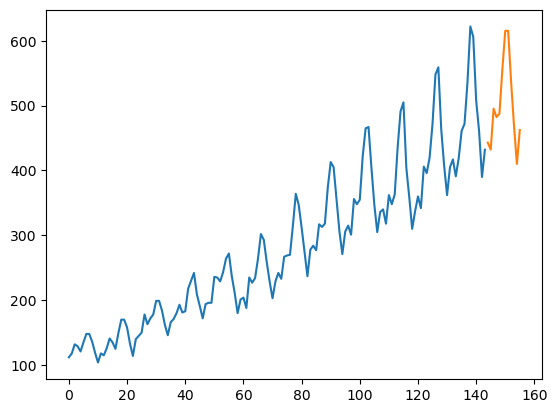

In [ ]:
#| hide
import matplotlib.pyplot as plt
res = auto_theta(ap, m=12)
fcst = forecast_theta(res, 12)
plt.plot(np.arange(0, len(ap)), ap)
plt.plot(np.arange(len(ap), len(ap) + 12), fcst['mean'])